# Random forest experimentation

In [55]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from sklearn import tree
from dtreeviz.trees import *

def jeremy_trick_RF_sample_size(n):
    # Jeremy's trick
    from sklearn.ensemble import forest
    forest._generate_sample_indices = \
        (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples,n))

## Error vs num trees

In [56]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

In [57]:
nchunks = 200
X, y = rent()
X_test, y_test, chunk_size = testobs(X, y, nchunks=nchunks)

In [58]:
max_features = 1.0      # use this to simulate bagging but not RF
max_features = 'auto'
min_samples_leaf=1      # lowest bias but increases variance

tree_sizes = [1,2,3,4,5,6,10,15,20,30,40,50]

all_test_scores = np.zeros(shape=(len(tree_sizes), nchunks-1)) # first chunk is test set
for i,n_estimators in enumerate(tree_sizes):
    print(f"{n_estimators} trees: ", end='')
    test_scores = []
    for j in range(1,nchunks): # first chunk is test set; skip
#         print(j,' ', end='')
        X_train = X[j*chunk_size:j*chunk_size+chunk_size]
        y_train = y[j*chunk_size:j*chunk_size+chunk_size]
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   bootstrap=True)
        rf.fit(X_train, y_train)
        s = rf.score(X_test, y_test)
        test_scores.append(s)

    all_test_scores[i] = test_scores
    avg = np.mean(test_scores)
    std = np.std(test_scores)
    print(avg, std)

1 trees: -0.5392479928470235 0.9801628249302649
2 trees: -0.1457938661448137 0.5234879543220444
3 trees: -0.14160615839228868 0.5782307174174021
4 trees: -0.04115527378485158 0.45650371624790026
5 trees: -0.020573246127091868 0.4890004633746785
6 trees: 0.006766685284755908 0.4672759509286699
10 trees: 0.026949532803711568 0.42848271517763503
15 trees: 0.04758684253632946 0.36410361558438326
20 trees: 0.06780882691227308 0.3517410630798866
30 trees: 0.0725101927692769 0.3623187955476831
40 trees: 0.08916776934514477 0.3593758898950675
50 trees: 0.08187320372440356 0.3525136789901566


In [59]:
test_means = np.mean(all_test_scores, axis=1)
test_variances = np.std(all_test_scores, axis=1)
test_variances

array([0.98016282, 0.52348795, 0.57823072, 0.45650372, 0.48900046,
       0.46727595, 0.42848272, 0.36410362, 0.35174106, 0.3623188 ,
       0.35937589, 0.35251368])

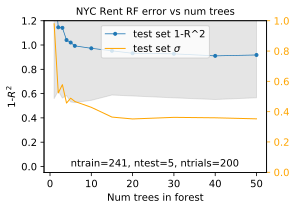

In [60]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, 1-test_means, lw=.75, marker='.', label="test set 1-R^2")

plt.fill_between(tree_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(tree_sizes, test_variances, lw=1, label="test set $\sigma$", c='orange')
ax2.yaxis.label.set_color('orange')
#ax2.set_ylabel("Test $\sigma$")
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,1)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("1-$R^2$")
ax.set_ylim(-.05,1.2)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='upper center')

ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==1.0:
    ax.set_title("NYC Rent bagged forest error vs num trees", fontsize=10)
else:
    ax.set_title("NYC Rent RF error vs num trees", fontsize=10)

## Synthetic data

In [61]:
def syndata(n = 100, ncols = 50):
    "Eqn 15.8 p599 ESLII Hastie et all"
    df = pd.DataFrame()
    for i in range(ncols):
        df[f'x{i}'] = np.random.normal(size=n)
    X = df.values
    y = np.sum(X,axis=1) / np.sqrt(ncols)# + np.random.normal(size=n)
    return X, y

In [62]:
def simulate(ntrials, max_features, min_samples_leaf=1, bootstrap=True):
#     tree_sizes = [1,2,3,4,5,6,7,8,9,10,20,30]#,40,50]#,200,400]
    tree_sizes = [10,20,30,40,50,100, 200, 300]
    all_test_errors = np.zeros(shape=(ntrials, len(tree_sizes)))
    all_test_scores = np.zeros(shape=(ntrials, len(tree_sizes)))

    # single test set
    X_test, y_test = syndata(n=600)

    print("Trial: ", end='')
    for i in range(ntrials):
        print(f"{i} ", end='')
        X_train, y_train = syndata(n=100) # new train set each trial

        error_per_tree_size = []
        r2_per_tree_size = []
        for n_estimators in tree_sizes:
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=bootstrap,
                                       n_jobs=-1)
            rf.fit(X_train, y_train)
#             y_pred = rf.predict(X_test)
#             e = mean_absolute_error(y_test, y_pred)
#             error_per_tree_size.append(e)
            s = rf.score(X_test, y_test)
            r2_per_tree_size.append(s)

#         all_test_errors[i] = error_per_tree_size
        all_test_scores[i] = r2_per_tree_size
    return all_test_errors, all_test_scores, tree_sizes

In [63]:
def showme(tree_sizes,all_test_errors,all_test_scores,max_features):
    test_means = np.mean(all_test_errors, axis=0)
    test_stds = np.std(all_test_errors, axis=0)
    test_variances = np.var(all_test_errors, axis=0)
    test_r2_means = np.mean(all_test_scores, axis=0)
    test_r2_stds = np.std(all_test_scores, axis=0)
    test_r2_variances = np.var(all_test_scores, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,2.8))
    a = ax.plot(tree_sizes, test_r2_means, lw=.75, marker='.', label="test $R^2$")

    plt.fill_between(tree_sizes, 
                     test_r2_means - test_r2_stds,
                     test_r2_means + test_r2_stds,
                     color='gray', alpha=0.2, label="test $R^2$ $3\sigma$")

    ax2 = ax.twinx()
    b = ax2.plot(tree_sizes, test_r2_stds, lw=1, label="test set stdev", c='orange')
    ax2.yaxis.label.set_color('orange')
    ax2.tick_params(axis='y', colors='orange')
    ax2.set_ylim(0,.4)

    ax.legend(loc='center right')
    ax.set_xlabel("Num trees in forest")
    ax.set_ylabel("Test set $R^2$")

    if max_features==1.0:
        ax.set_title(f"BAGGING test error vs num trees, {min_samples_leaf} samples/leaf", fontsize=10)
    else:
        ax.set_title(f"RF rest error vs num trees, {min_samples_leaf} samples/leaf", fontsize=10) 

In [64]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=50, max_features='auto')

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

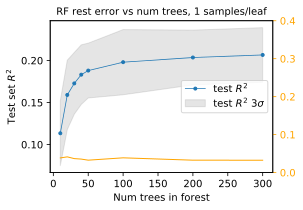

In [65]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features='auto')

In [66]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=50, max_features=1.0)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

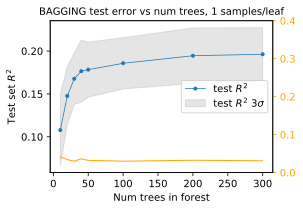

In [67]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1.0)

In [68]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=50, max_features=1)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

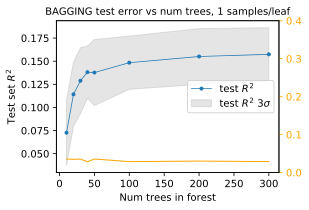

In [69]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1)

In [70]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=100, max_features='auto')

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

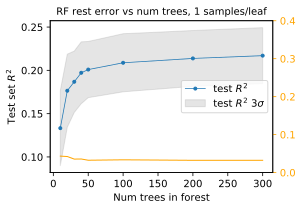

In [71]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features='auto')

In [72]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=100, max_features=1.0)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

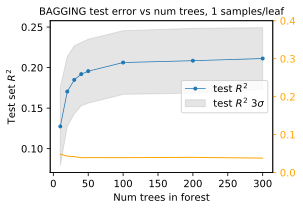

In [73]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1.0)

In [74]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=100, max_features=1)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

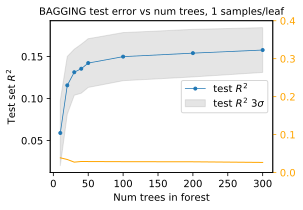

In [75]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1)